In [0]:

import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [4]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

0it [00:00, ?it/s]

9920512it [00:02, 3381963.24it/s]                             


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 54613.02it/s]                           
0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


1654784it [00:01, 940429.79it/s]                             
0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


8192it [00:00, 21198.13it/s]            

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


In [5]:

X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [6]:
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [0]:
X_train = X_train.float()
X_test = X_test.float()

In [8]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [9]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

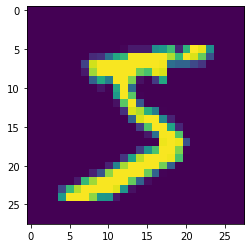

tensor(5)


In [10]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [0]:
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

In [0]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10) 
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x
    
mnist_net = MNISTNet(100)

In [21]:
 torch.cuda.is_available()

True

In [14]:
 !nvidia-smi

Sat Dec  7 20:14:11 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    27W / 149W |     11MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [22]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mnist_net = mnist_net.to(device)
list(mnist_net.parameters())


[Parameter containing:
 tensor([[ 0.0255, -0.0269, -0.0041,  ...,  0.0281,  0.0076, -0.0123],
         [-0.0196,  0.0333, -0.0029,  ...,  0.0192, -0.0170, -0.0292],
         [-0.0333, -0.0296,  0.0156,  ...,  0.0350, -0.0079,  0.0280],
         ...,
         [ 0.0340, -0.0156, -0.0035,  ..., -0.0062, -0.0263, -0.0262],
         [-0.0156, -0.0011,  0.0201,  ..., -0.0020, -0.0187,  0.0116],
         [ 0.0058,  0.0027,  0.0108,  ..., -0.0298, -0.0246,  0.0105]],
        device='cuda:0', requires_grad=True), Parameter containing:
 tensor([ 0.0111,  0.0118,  0.0256, -0.0345,  0.0340,  0.0239,  0.0243, -0.0216,
         -0.0045,  0.0121, -0.0137,  0.0015,  0.0110,  0.0011,  0.0278,  0.0243,
          0.0039,  0.0322,  0.0351, -0.0352, -0.0090, -0.0100, -0.0172, -0.0350,
         -0.0219, -0.0132, -0.0020, -0.0202,  0.0219,  0.0080,  0.0270,  0.0219,
         -0.0120, -0.0025,  0.0289, -0.0333, -0.0318, -0.0193,  0.0249,  0.0001,
         -0.0241, -0.0061, -0.0267,  0.0185,  0.0136, -0.0038, 

In [0]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

In [24]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(10000):
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = mnist_net.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()

    test_preds = mnist_net.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test))
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    test_accuracy_history.append(accuracy)
    print(accuracy)

tensor(0.9110, device='cuda:0')
tensor(0.9229, device='cuda:0')
tensor(0.9237, device='cuda:0')
tensor(0.9250, device='cuda:0')
tensor(0.9200, device='cuda:0')
tensor(0.9257, device='cuda:0')
tensor(0.9292, device='cuda:0')
tensor(0.9332, device='cuda:0')
tensor(0.9333, device='cuda:0')
tensor(0.9331, device='cuda:0')
tensor(0.9351, device='cuda:0')
tensor(0.9362, device='cuda:0')
tensor(0.9372, device='cuda:0')
tensor(0.9365, device='cuda:0')
tensor(0.9376, device='cuda:0')
tensor(0.9409, device='cuda:0')


KeyboardInterrupt: ignored

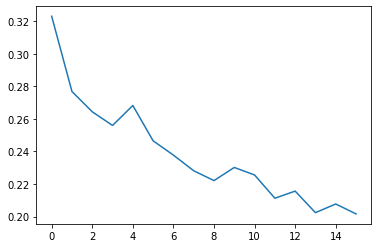

In [27]:

#plt.plot(test_accuracy_history)
plt.plot(test_loss_history);